In [1]:
!pip install -U albumentations opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


Подключаем диск

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Импортируем библиотеки

In [3]:
import tarfile
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from tqdm import tqdm
import os
from torchvision import datasets, models
import torch.nn as nn
from torch.optim import lr_scheduler
import time

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Подгружаем данные

In [5]:
!cp /content/drive/MyDrive/data/caltech256/256_ObjectCategories.tar .
!cp /content/drive/MyDrive/data/caltech256/*.txt .

file = tarfile.open("256_ObjectCategories.tar")
file.extractall()
file.close()

In [6]:
!ls

256_ObjectCategories  256_ObjectCategories.tar	drive  sample_data  train_lst.txt  val_lst.txt


Соберем датафреймы с путями и метками классов для обучающего набора данных и тестового

In [7]:
with open("train_lst.txt", "r") as f:
  train_paths = f.readlines()

train_paths = [curr_path[:-1] for curr_path in train_paths]

with open("val_lst.txt", "r") as f:
  val_paths = f.readlines()

val_paths = [curr_path[:-1] for curr_path in val_paths]

In [8]:
len(train_paths) + len(val_paths)

23918

In [9]:
dict_train = {
  "path": [],
  "label_idx": [],
  "label": []
}

dict_val = {
  "path": [],
  "label_idx": [],
  "label": []
}

for item in train_paths:
  curr_path, curr_label_idx, curr_label = item.split(" ")
  dict_train["path"].append(curr_path)
  dict_train["label_idx"].append(curr_label_idx)
  dict_train["label"].append(curr_label)

for item in val_paths:
  curr_path, curr_label_idx, curr_label = item.split(" ")
  dict_val["path"].append(curr_path)
  dict_val["label_idx"].append(curr_label_idx)
  dict_val["label"].append(curr_label)

In [10]:
df_train = pd.DataFrame(
    dict_train
)

df_val = pd.DataFrame(
    dict_val
)

Проверим, что все классы, которые есть в валидации, есть и в обучающем наборе

In [11]:
set(df_train["label"].values) - set(df_val["label"].values)

set()

In [12]:
set(df_val["label"].values) - set(df_train["label"].values)

set()

Опишем класс датасет для взаимодействия с данными

In [13]:
class CaltechDataset(Dataset):
  def __init__(self, df, transforms):
    self.df = df
    self.transforms = transforms
    self.idx2label = {idx: self.df[self.df.label_idx == idx].label.values[0] for idx in set(self.df.label_idx.values)}
    self.label2idx = {label: idx for idx, label in self.idx2label.items()}

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx].path
    label_idx = self.df.iloc[idx].label_idx

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug = self.transforms(image=img)
    img = aug["image"]

    return img, int(label_idx)

  def __len__(self):
    return len(self.df)

Трансформации

In [14]:
transforms_train = A.Compose([
    A.RandomRes
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Rotate(30, p=0.3),
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

transforms_val = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

Объявим датасеты

In [32]:
train_dataset = CaltechDataset(df_train, transforms_train)
val_dataset = CaltechDataset(df_val, transforms_val)

image_datasets = {
    "train": train_dataset,
    "val": val_dataset,
}

In [33]:
img, _ = val_dataset[1]
img.shape

torch.Size([3, 256, 256])

Зададим dataloaders

In [34]:
dataloaders = {
    data_type: DataLoader(
        image_datasets[data_type],
        batch_size=32,
        shuffle=True
        )
    for data_type in ["train", "val"]
}

dataset_sizes = {
    data_type: len(image_datasets[data_type]) for data_type in ['train', 'val']
    }

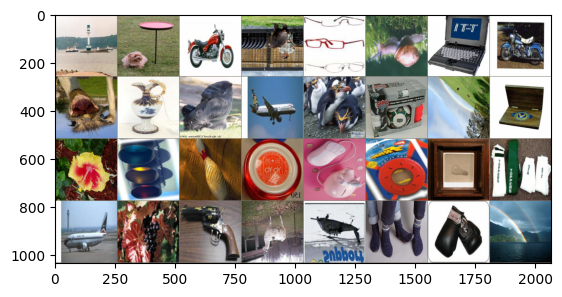

In [35]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Функция для тренировки модели

In [36]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f3540e43280>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f3569007610>}

In [37]:
#scheduler отвечает за изменение lr со временем в процессе обучения
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Обучение resnet18 с нуля

In [38]:
model = models.resnet18()

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 256)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.AdamW(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [41]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


100%|██████████| 565/565 [02:34<00:00,  3.65it/s]


train Loss: 5.1897 Acc: 0.0632


100%|██████████| 184/184 [00:31<00:00,  5.77it/s]


val Loss: 4.9263 Acc: 0.0872

Epoch 1/9
----------


100%|██████████| 565/565 [02:30<00:00,  3.76it/s]


train Loss: 4.7695 Acc: 0.0966


100%|██████████| 184/184 [00:32<00:00,  5.73it/s]


val Loss: 4.5926 Acc: 0.1175

Epoch 2/9
----------


100%|██████████| 565/565 [02:30<00:00,  3.76it/s]


train Loss: 4.5083 Acc: 0.1244


100%|██████████| 184/184 [00:32<00:00,  5.71it/s]


val Loss: 4.3659 Acc: 0.1441

Epoch 3/9
----------


100%|██████████| 565/565 [02:30<00:00,  3.77it/s]


train Loss: 4.2719 Acc: 0.1489


100%|██████████| 184/184 [00:31<00:00,  5.81it/s]


val Loss: 4.2896 Acc: 0.1586

Epoch 4/9
----------


100%|██████████| 565/565 [02:30<00:00,  3.77it/s]


train Loss: 4.0275 Acc: 0.1788


100%|██████████| 184/184 [00:31<00:00,  5.77it/s]


val Loss: 3.9973 Acc: 0.1972

Epoch 5/9
----------


100%|██████████| 565/565 [02:32<00:00,  3.71it/s]


train Loss: 3.7955 Acc: 0.2077


100%|██████████| 184/184 [00:32<00:00,  5.72it/s]


val Loss: 3.7717 Acc: 0.2259

Epoch 6/9
----------


100%|██████████| 565/565 [02:29<00:00,  3.78it/s]


train Loss: 3.5691 Acc: 0.2416


100%|██████████| 184/184 [00:34<00:00,  5.40it/s]


val Loss: 3.6443 Acc: 0.2549

Epoch 7/9
----------


100%|██████████| 565/565 [02:29<00:00,  3.79it/s]


train Loss: 3.1336 Acc: 0.3152


100%|██████████| 184/184 [00:33<00:00,  5.47it/s]


val Loss: 3.2717 Acc: 0.3113

Epoch 8/9
----------


100%|██████████| 565/565 [02:26<00:00,  3.85it/s]


train Loss: 3.0093 Acc: 0.3309


100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


val Loss: 3.2177 Acc: 0.3204

Epoch 9/9
----------


100%|██████████| 565/565 [02:28<00:00,  3.81it/s]


train Loss: 2.9293 Acc: 0.3436


100%|██████████| 184/184 [00:31<00:00,  5.91it/s]


val Loss: 3.1755 Acc: 0.3303

Training complete in 30m 25s
Best val Acc: 0.330263


В чем отличие BasicBlock и Bottleneck блок?

The bottleneck of TorchVision places the stride for downsampling to the second 3x3 convolution while the original paper places it to the first 1x1 convolution. This variant improves the accuracy and is known as ResNet V1.5.

https://catalog.ngc.nvidia.com/orgs/nvidia/resources/resnet_50_v1_5_for_pytorch

Собственноручно написанный resnet18

In [ ]:
class MyResnet18(nn.Module):
  def __init__(self):
    pass

  def forward(self):
    pass

Идеи и дальнейшие шаги:

1. KLDIVLOSS
2. MULTIMARGINLOSS
3.